# **Add additional meteo data**
- Collect additional meteo data from various sources: `SWC` `TS` `PREC`

# Imports

In [1]:
DIRCONF = r'F:\Sync\luhk_work\20 - CODING\22 - POET\configs'
TIMEZONE_OFFSET_TO_UTC_HOURS = 1  # Timezone, e.g. "1" is translated to timezone "UTC+01:00" (CET, winter time)
REQUIRED_TIME_RESOLUTION = '30min'  # 30MIN time resolution

from pathlib import Path
import importlib.metadata
import pandas as pd
from dbc_influxdb import dbcInflux
from diive.core.io.files import load_parquet, save_parquet
from diive.core.times.times import TimestampSanitizer
from diive.pkgs.createvar.timesince import TimeSince
from influxdb_client.client.warnings import MissingPivotFunction
import warnings
warnings.filterwarnings(action='ignore', category=MissingPivotFunction)

version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")
version_dbc = importlib.metadata.version("dbc_influxdb")
print(f"dbc-influxdb version: v{version_dbc}")
dbc = dbcInflux(dirconf=DIRCONF)  # Connect to database

diive version: v0.85.0
dbc-influxdb version: v0.12.0
Reading configuration files was successful.
Connection to database works.


# Load meteo data so far (M7)

In [2]:
meteo7 = load_parquet(filepath="16.1_CH-CHA_meteo7_gapfilled_2005-2023.parquet")
meteo7

Loaded .parquet file 16.1_CH-CHA_meteo7_gapfilled_2005-2023.parquet (0.044 seconds). Detected time resolution of <30 * Minutes> / 30min 


,LW_IN_T1_2_1,PA_GF1_0.9_1,FLAG_PA_GF1_0.9_1_ISFILLED,PPFD_IN_T1_2_2,FLAG_PPFD_IN_T1_2_2_ISFILLED,VPD_T1_2_1,FLAG_VPD_T1_2_1_ISFILLED,SW_IN_T1_2_1,FLAG_SW_IN_T1_2_1_ISFILLED,TA_T1_2_1,FLAG_TA_T1_2_1_ISFILLED,RH_T1_2_1,FLAG_RH_T1_2_1_ISFILLED
TIMESTAMP_MIDDLE,,,,,,,,,,,,,
2005-01-01 00:15:00,NaN,978.100000,1.0,0.0,0,0.099893,0,0.0,3.0,1.566667,3.0,85.400000,1.0
2005-01-01 00:45:00,NaN,977.933333,1.0,0.0,0,0.097606,0,0.0,3.0,1.533333,3.0,85.700000,1.0
2005-01-01 01:15:00,NaN,977.900000,1.0,0.0,0,0.091683,0,0.0,3.0,1.566667,3.0,86.600000,1.0
2005-01-01 01:45:00,NaN,977.833333,1.0,0.0,0,0.071157,0,0.0,3.0,1.566667,3.0,89.600000,1.0
2005-01-01 02:15:00,NaN,977.833333,1.0,0.0,0,0.058333,0,0.0,3.0,1.500000,3.0,91.433333,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:45:00,327.407107,964.969617,NaN,0.0,0,0.003675,0,0.0,0.0,1.540578,0.0,99.461884,NaN
2023-12-31 22:15:00,327.958383,965.049553,NaN,0.0,0,0.007970,0,0.0,0.0,2.051889,0.0,98.875075,NaN
2023-12-31 22:45:00,328.605910,965.261047,NaN,0.0,0,0.017429,0,0.0,0.0,2.223067,0.0,97.569925,NaN


# Load additional meteo data from Feigenwinter et al. (2023a) (2005-2020)

- Variables: `G`  `PREC` `LW_OUT` `SW_OUT` `SWC` `TS`

In [3]:
# Load data from Feigenwinter et al. (2023a)
df_feigenw_2005_2020 = load_parquet(filepath="13.1_CH-CHA_FEIGENW_meteo_2005-2020.parquet")
keepcols = [
    'PREC_RAIN_TOT_GF1_0.5_1',
    'FLAG_PREC_RAIN_TOT_GF1_0.5_1_ISFILLED',
    'SWC_GF1_0.05_1',
    'SWC_GF1_0.15_1',
    'SWC_GF1_0.75_1',
    'TS_GF1_0.04_1',
    'TS_GF1_0.15_1',
    'TS_GF1_0.4_1'
]
df_feigenw_2005_2020 = df_feigenw_2005_2020[keepcols].copy()
df_feigenw_2005_2020

Loaded .parquet file 13.1_CH-CHA_FEIGENW_meteo_2005-2020.parquet (0.030 seconds). Detected time resolution of <30 * Minutes> / 30min 


,PREC_RAIN_TOT_GF1_0.5_1,FLAG_PREC_RAIN_TOT_GF1_0.5_1_ISFILLED,SWC_GF1_0.05_1,SWC_GF1_0.15_1,SWC_GF1_0.75_1,TS_GF1_0.04_1,TS_GF1_0.15_1,TS_GF1_0.4_1
TIMESTAMP_MIDDLE,,,,,,,,
2005-01-01 00:15:00,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-01 00:45:00,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-01 01:15:00,0.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-01 01:45:00,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-01 02:15:00,0.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-12-31 21:45:00,0.0,0.0,43.15512,37.83649,42.34799,7.059905,4.751553,5.665280
2020-12-31 22:15:00,0.0,0.0,43.14826,37.83116,42.34475,7.037867,4.753286,5.666638
2020-12-31 22:45:00,0.0,0.0,43.14190,37.82694,42.34330,7.021161,4.754451,5.668180


# Load meteo data from FLUXNET v2024 (2021-2023)

- Variables: `PREC`

In [4]:
%%time
df_fluxnet_prec_2021_2023, data_detailed_fluxnet, assigned_measurements_fluxnet = dbc.download(
    bucket=f'ch-cha_processed',
    measurements=['PREC'],
    fields=['PREC_F', 'PREC_F_QC'],
    start='2021-01-01 00:00:01',  # Download data starting with this date (the start date itself IS included),
    stop='2024-01-01 00:00:01',  # Download data before this date (the stop date itself IS NOT included),
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version='fluxnet_v2024'
)


DOWNLOADING
    from bucket ch-cha_processed
    variables ['PREC_F', 'PREC_F_QC']
    from measurements ['PREC']
    from data version fluxnet_v2024
    between 2021-01-01 00:00:01 and 2024-01-01 00:00:01
    with timezone offset to UTC of 1
Used querystring: from(bucket: "ch-cha_processed") |> range(start: 2021-01-01T00:00:01+01:00, stop: 2024-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "PREC") |> filter(fn: (r) => r["data_version"] == "fluxnet_v2024") |> filter(fn: (r) => r["_field"] == "PREC_F" or r["_field"] == "PREC_F_QC") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
querystring was constructed from:
    bucketstring: from(bucket: "ch-cha_processed")
    rangestring: |> range(start: 2021-01-01T00:00:01+01:00, stop: 2024-01-01T00:00:01+01:00)
    measurementstring: |> filter(fn: (r) => r["_measurement"] == "PREC")
    dataversionstring: |> filter(fn: (r) => r["data_version"] == "fluxnet_v2024")
    fieldstring: |> filter(fn: (r) => 

In [5]:
df_fluxnet_prec_2021_2023

,PREC_F,PREC_F_QC
TIMESTAMP_END,,
2021-01-01 00:30:00,0.0,0.0
2021-01-01 01:00:00,0.0,0.0
2021-01-01 01:30:00,0.0,0.0
2021-01-01 02:00:00,0.0,0.0
2021-01-01 02:30:00,0.0,0.0
...,...,...
2023-12-31 22:00:00,0.0,0.0
2023-12-31 22:30:00,0.0,0.0
2023-12-31 23:00:00,0.0,0.0


## Sanitize timestamp

In [6]:
df_fluxnet_prec_2021_2023 = TimestampSanitizer(data=df_fluxnet_prec_2021_2023, output_middle_timestamp=True).get()
df_fluxnet_prec_2021_2023

,PREC_F,PREC_F_QC
TIMESTAMP_MIDDLE,,
2021-01-01 00:15:00,0.0,0.0
2021-01-01 00:45:00,0.0,0.0
2021-01-01 01:15:00,0.0,0.0
2021-01-01 01:45:00,0.0,0.0
2021-01-01 02:15:00,0.0,0.0
...,...,...
2023-12-31 21:45:00,0.0,0.0
2023-12-31 22:15:00,0.0,0.0
2023-12-31 22:45:00,0.0,0.0


# Load meteo data from database, screened with `diive` (2021-2023)

- Variables: `SWC` `TS`

In [7]:
%%time
df_diive_2021_2023, data_detailed, assigned_measurements = dbc.download(
    bucket=f'ch-cha_processed',
    measurements=['SWC', 'TS'],
    fields=[
        'SWC_GF1_0.05_1',
        'SWC_GF1_0.15_1',
        'SWC_GF1_0.2_1',
        'SWC_LOWRES_GF1_0.75_3',
        'TS_LOWRES_GF1_0.05_3',
        'TS_LOWRES_GF1_0.2_3',
        'TS_LOWRES_GF1_0.4_3'
    ],
    start='2021-01-01 00:00:01',  # Download data starting with this date (the start date itself IS included),
    stop='2024-01-01 00:00:01',  # Download data before this date (the stop date itself IS NOT included),
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version='meteoscreening_diive'
)


DOWNLOADING
    from bucket ch-cha_processed
    variables ['SWC_GF1_0.05_1', 'SWC_GF1_0.15_1', 'SWC_GF1_0.2_1', 'SWC_LOWRES_GF1_0.75_3', 'TS_LOWRES_GF1_0.05_3', 'TS_LOWRES_GF1_0.2_3', 'TS_LOWRES_GF1_0.4_3']
    from measurements ['SWC', 'TS']
    from data version meteoscreening_diive
    between 2021-01-01 00:00:01 and 2024-01-01 00:00:01
    with timezone offset to UTC of 1
Used querystring: from(bucket: "ch-cha_processed") |> range(start: 2021-01-01T00:00:01+01:00, stop: 2024-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "SWC" or r["_measurement"] == "TS") |> filter(fn: (r) => r["data_version"] == "meteoscreening_diive") |> filter(fn: (r) => r["_field"] == "SWC_GF1_0.05_1" or r["_field"] == "SWC_GF1_0.15_1" or r["_field"] == "SWC_GF1_0.2_1" or r["_field"] == "SWC_LOWRES_GF1_0.75_3" or r["_field"] == "TS_LOWRES_GF1_0.05_3" or r["_field"] == "TS_LOWRES_GF1_0.2_3" or r["_field"] == "TS_LOWRES_GF1_0.4_3") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn:

In [8]:
df_diive_2021_2023

,SWC_GF1_0.05_1,SWC_GF1_0.15_1,SWC_GF1_0.2_1,SWC_LOWRES_GF1_0.75_3,TS_LOWRES_GF1_0.05_3,TS_LOWRES_GF1_0.2_3,TS_LOWRES_GF1_0.4_3
TIMESTAMP_END,,,,,,,
2021-01-01 00:30:00,43.126695,37.815501,NaN,42.622617,3.180832,4.691608,5.775482
2021-01-01 01:00:00,43.122169,37.812458,NaN,42.833337,3.182800,4.680240,5.780918
2021-01-01 01:30:00,43.115942,37.807812,NaN,42.705397,3.153244,4.672886,5.782277
2021-01-01 02:00:00,43.111309,37.804945,NaN,42.746237,3.153244,4.662855,5.790431
2021-01-01 02:30:00,43.106277,37.800922,NaN,42.731170,3.166388,4.653491,5.793149
...,...,...,...,...,...,...,...
2023-12-31 22:00:00,44.289772,NaN,54.852594,52.856753,3.359719,4.942291,6.010860
2023-12-31 22:30:00,44.140854,NaN,54.864339,52.826993,3.220912,4.944976,6.011540
2023-12-31 23:00:00,44.013164,NaN,54.873537,52.912827,3.148644,4.941619,6.014273


## Sanitize timestamp

In [9]:
df_diive_2021_2023 = TimestampSanitizer(data=df_diive_2021_2023, output_middle_timestamp=True).get()
df_diive_2021_2023

,SWC_GF1_0.05_1,SWC_GF1_0.15_1,SWC_GF1_0.2_1,SWC_LOWRES_GF1_0.75_3,TS_LOWRES_GF1_0.05_3,TS_LOWRES_GF1_0.2_3,TS_LOWRES_GF1_0.4_3
TIMESTAMP_MIDDLE,,,,,,,
2021-01-01 00:15:00,43.126695,37.815501,NaN,42.622617,3.180832,4.691608,5.775482
2021-01-01 00:45:00,43.122169,37.812458,NaN,42.833337,3.182800,4.680240,5.780918
2021-01-01 01:15:00,43.115942,37.807812,NaN,42.705397,3.153244,4.672886,5.782277
2021-01-01 01:45:00,43.111309,37.804945,NaN,42.746237,3.153244,4.662855,5.790431
2021-01-01 02:15:00,43.106277,37.800922,NaN,42.731170,3.166388,4.653491,5.793149
...,...,...,...,...,...,...,...
2023-12-31 21:45:00,44.289772,NaN,54.852594,52.856753,3.359719,4.942291,6.010860
2023-12-31 22:15:00,44.140854,NaN,54.864339,52.826993,3.220912,4.944976,6.011540
2023-12-31 22:45:00,44.013164,NaN,54.873537,52.912827,3.148644,4.941619,6.014273


</br>

---

# **MERGE DATA**
- Start with meteo7, then add data

## Meteo7 (2005-2023)

Index duplicates: 0
Column duplicates: 0


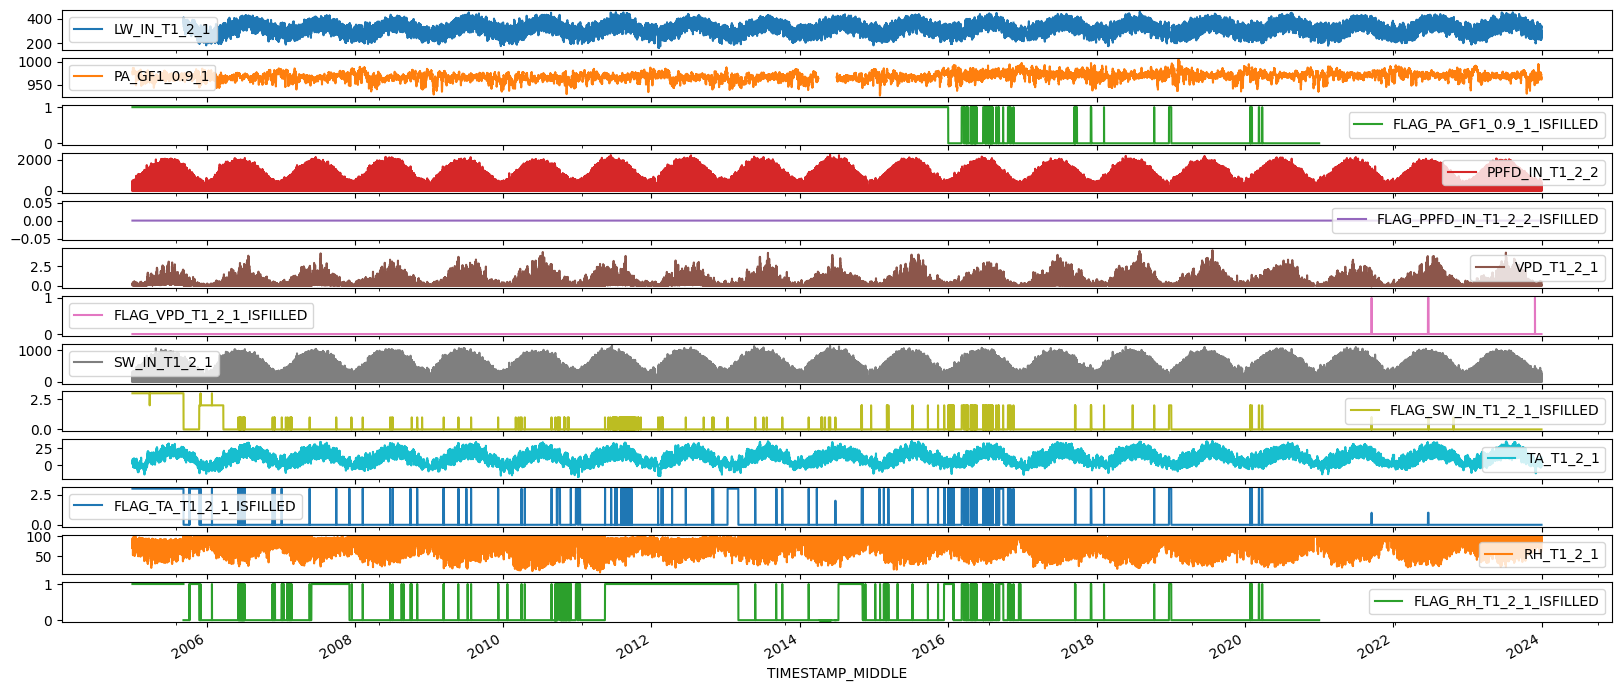

In [10]:
df_merged = meteo7.copy()
df_merged.plot(x_compat=True, subplots=True, figsize=(20, 9));
print(f"Index duplicates: {df_merged.index.duplicated().sum()}")
print(f"Column duplicates: {df_merged.columns.duplicated().sum()}")

## `PREC` `SWC` `TS` from Feigenwinter (2005-2020) [new columns]

Index duplicates: 0
Column duplicates: 0


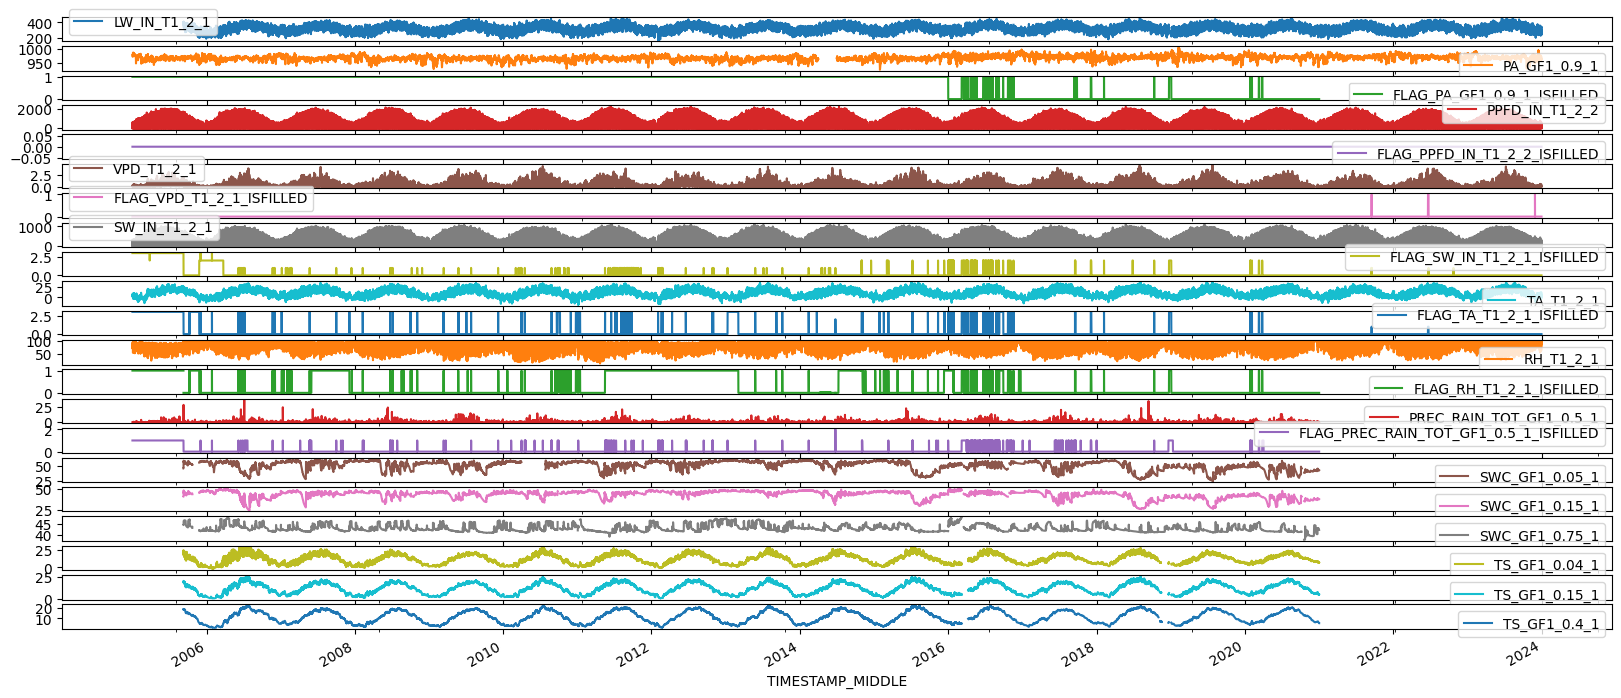

In [11]:
df_merged = pd.concat([df_merged, df_feigenw_2005_2020], axis=1)
df_merged.plot(x_compat=True, subplots=True, figsize=(20, 9));
print(f"Index duplicates: {df_merged.index.duplicated().sum()}")
print(f"Column duplicates: {df_merged.columns.duplicated().sum()}")

## `PREC` from FLUXNET (2021-2023) [add to existing column and 1 new column]

Index duplicates: 0
Column duplicates: 0


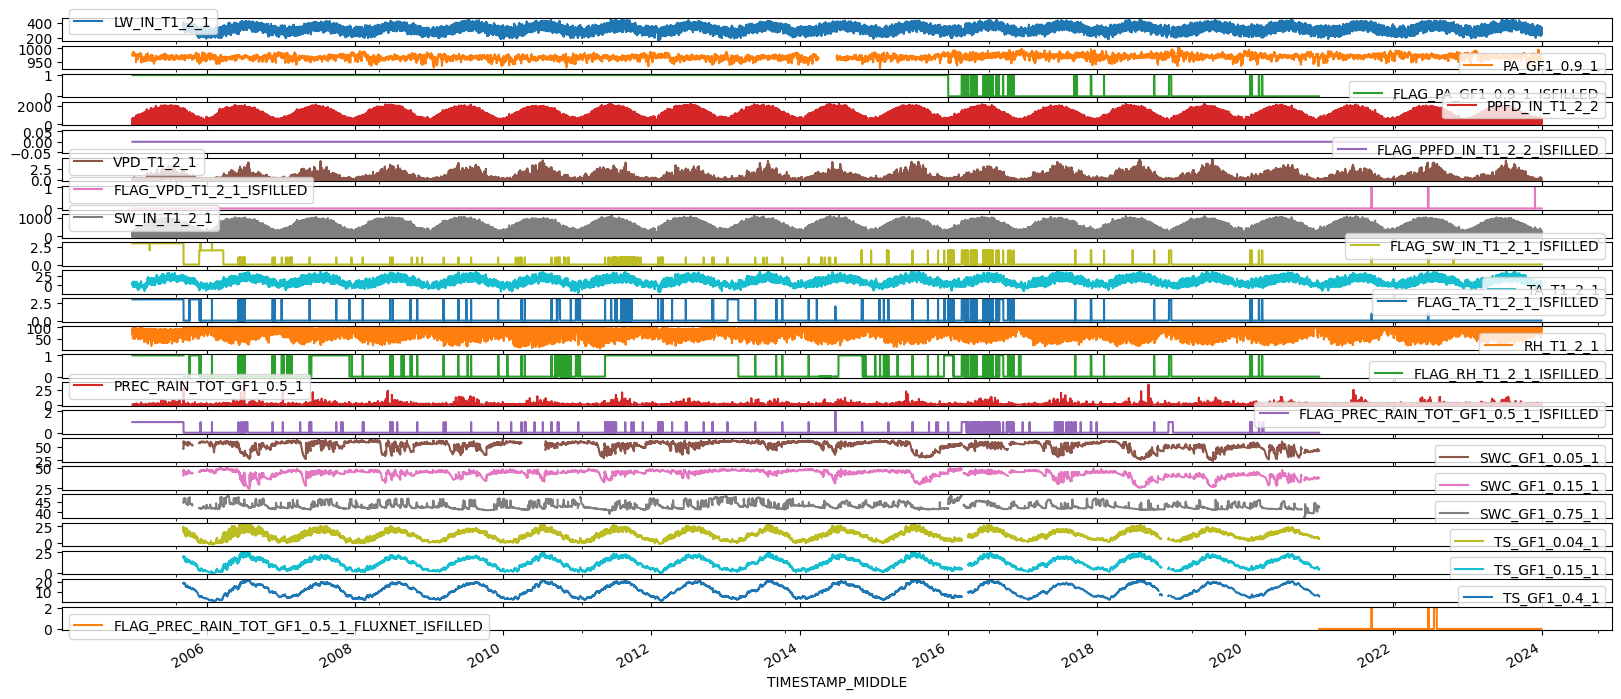

In [12]:
rename_dict = {
    'PREC_F': 'PREC_RAIN_TOT_GF1_0.5_1',
    'PREC_F_QC': 'FLAG_PREC_RAIN_TOT_GF1_0.5_1_FLUXNET_ISFILLED'
}
df_fluxnet_prec_2021_2023 = df_fluxnet_prec_2021_2023.rename(columns=rename_dict, inplace=False)

df_merged['PREC_RAIN_TOT_GF1_0.5_1'] = df_merged['PREC_RAIN_TOT_GF1_0.5_1'].fillna(df_fluxnet_prec_2021_2023['PREC_RAIN_TOT_GF1_0.5_1'])
df_merged['FLAG_PREC_RAIN_TOT_GF1_0.5_1_FLUXNET_ISFILLED'] = df_fluxnet_prec_2021_2023['FLAG_PREC_RAIN_TOT_GF1_0.5_1_FLUXNET_ISFILLED']

df_merged.plot(x_compat=True, subplots=True, figsize=(20, 9));
print(f"Index duplicates: {df_merged.index.duplicated().sum()}")
print(f"Column duplicates: {df_merged.columns.duplicated().sum()}")

## `SWC` from diive (2021-2023) [add to existing columns]

Index duplicates: 0
Column duplicates: 0


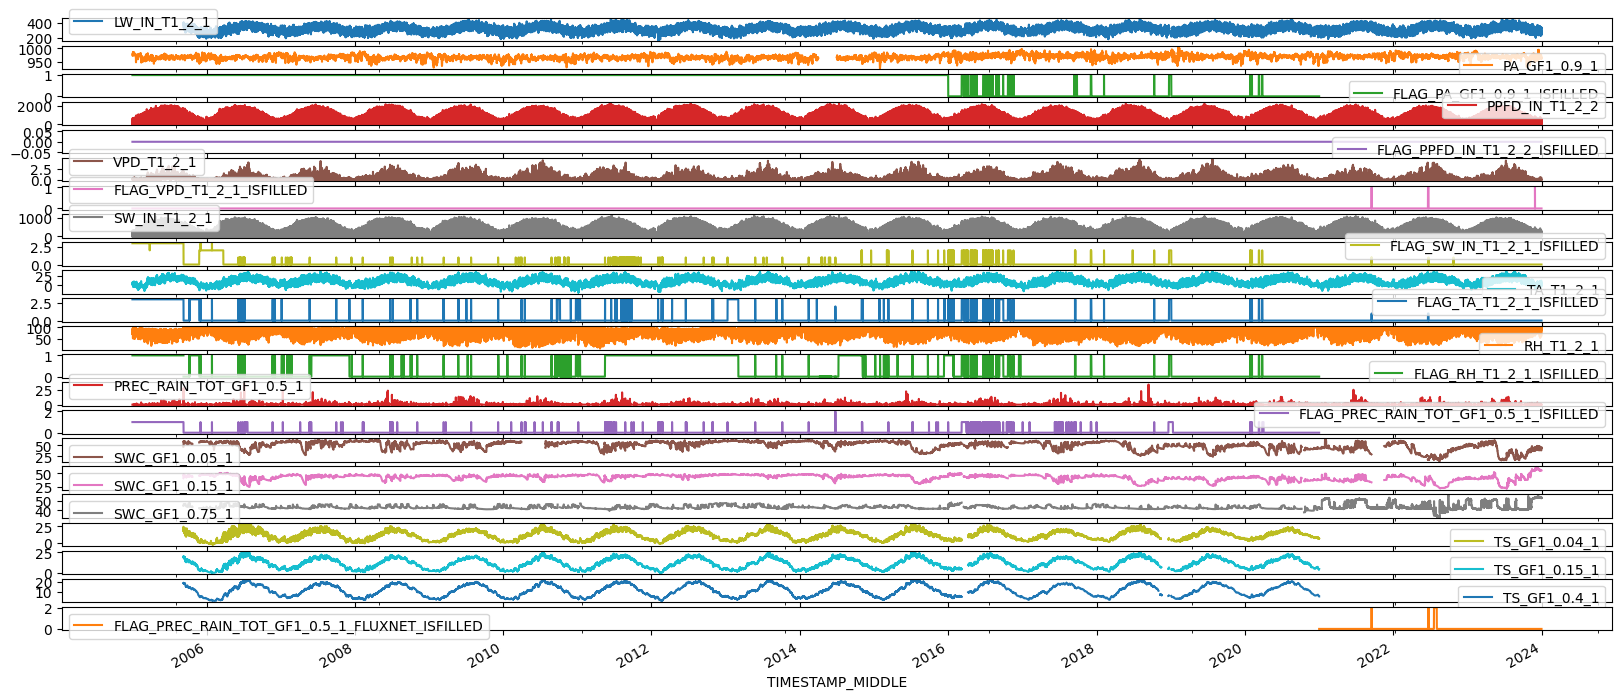

In [13]:
df_merged['SWC_GF1_0.05_1'] = df_merged['SWC_GF1_0.05_1'].fillna(df_diive_2021_2023['SWC_GF1_0.05_1'])
df_merged['SWC_GF1_0.15_1'] = df_merged['SWC_GF1_0.15_1'].fillna(df_diive_2021_2023['SWC_GF1_0.15_1'])
df_merged['SWC_GF1_0.15_1'] = df_merged['SWC_GF1_0.15_1'].fillna(df_diive_2021_2023['SWC_GF1_0.2_1'])
df_merged['SWC_GF1_0.75_1'] = df_merged['SWC_GF1_0.75_1'].fillna(df_diive_2021_2023['SWC_LOWRES_GF1_0.75_3'])
df_merged.plot(x_compat=True, subplots=True, figsize=(20, 9));
print(f"Index duplicates: {df_merged.index.duplicated().sum()}")
print(f"Column duplicates: {df_merged.columns.duplicated().sum()}")

## `TS` from diive (2021-2023) [add to existing columns]

Index duplicates: 0
Column duplicates: 0


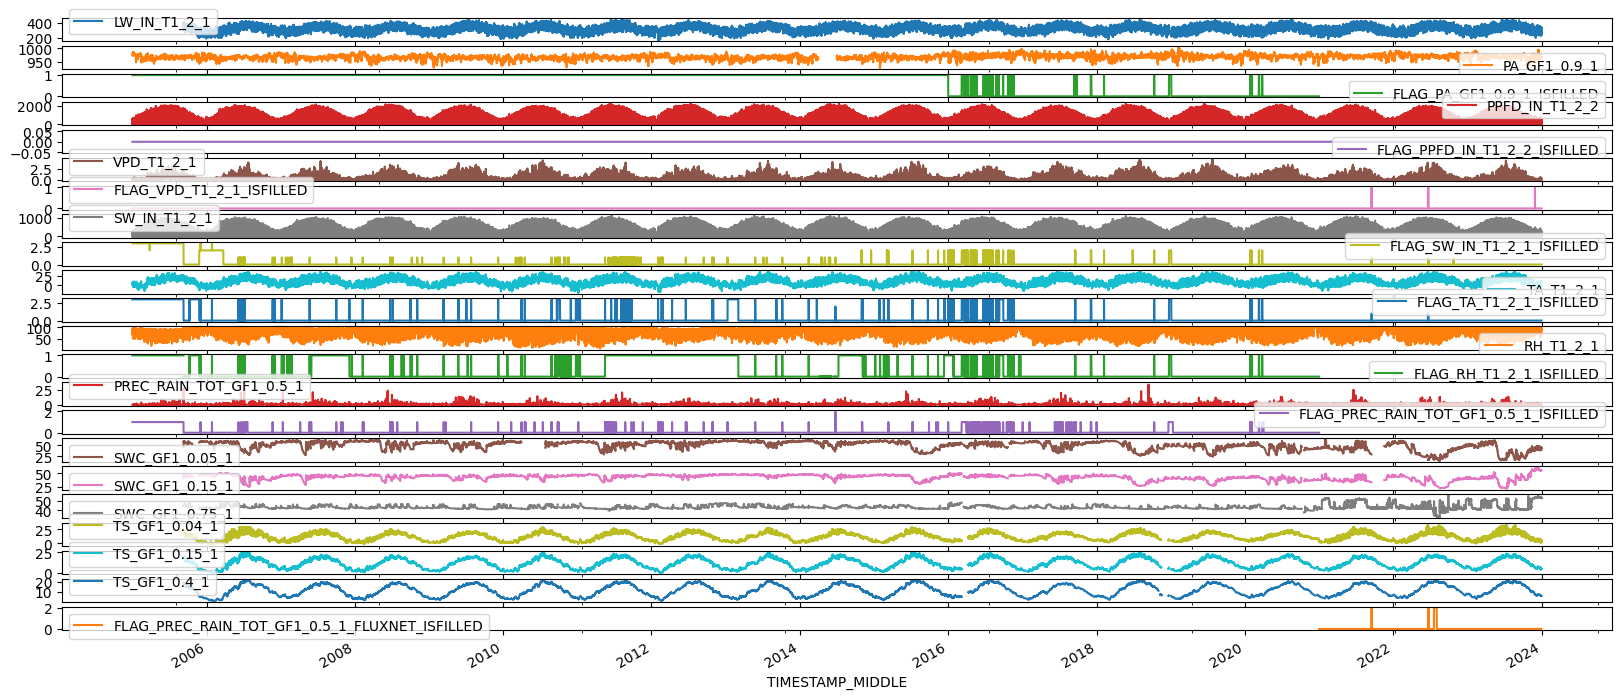

In [14]:
df_merged['TS_GF1_0.04_1'] = df_merged['TS_GF1_0.04_1'].fillna(df_diive_2021_2023['TS_LOWRES_GF1_0.05_3'])
df_merged['TS_GF1_0.15_1'] = df_merged['TS_GF1_0.15_1'].fillna(df_diive_2021_2023['TS_LOWRES_GF1_0.2_3'])
df_merged['TS_GF1_0.4_1'] = df_merged['TS_GF1_0.4_1'].fillna(df_diive_2021_2023['TS_LOWRES_GF1_0.4_3'])
df_merged.plot(x_compat=True, subplots=True, figsize=(20, 9));
print(f"Index duplicates: {df_merged.index.duplicated().sum()}")
print(f"Column duplicates: {df_merged.columns.duplicated().sum()}")

## Sanitize timestamp

In [15]:
df_merged = TimestampSanitizer(data=df_merged, output_middle_timestamp=False).get()
df_merged

,LW_IN_T1_2_1,PA_GF1_0.9_1,FLAG_PA_GF1_0.9_1_ISFILLED,PPFD_IN_T1_2_2,FLAG_PPFD_IN_T1_2_2_ISFILLED,VPD_T1_2_1,FLAG_VPD_T1_2_1_ISFILLED,SW_IN_T1_2_1,FLAG_SW_IN_T1_2_1_ISFILLED,TA_T1_2_1,FLAG_TA_T1_2_1_ISFILLED,RH_T1_2_1,FLAG_RH_T1_2_1_ISFILLED,PREC_RAIN_TOT_GF1_0.5_1,FLAG_PREC_RAIN_TOT_GF1_0.5_1_ISFILLED,SWC_GF1_0.05_1,SWC_GF1_0.15_1,SWC_GF1_0.75_1,TS_GF1_0.04_1,TS_GF1_0.15_1,TS_GF1_0.4_1,FLAG_PREC_RAIN_TOT_GF1_0.5_1_FLUXNET_ISFILLED
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,,
2005-01-01 00:15:00,NaN,978.100000,1.0,0.0,0,0.099893,0,0.0,3.0,1.566667,3.0,85.400000,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-01 00:45:00,NaN,977.933333,1.0,0.0,0,0.097606,0,0.0,3.0,1.533333,3.0,85.700000,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-01 01:15:00,NaN,977.900000,1.0,0.0,0,0.091683,0,0.0,3.0,1.566667,3.0,86.600000,1.0,0.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-01 01:45:00,NaN,977.833333,1.0,0.0,0,0.071157,0,0.0,3.0,1.566667,3.0,89.600000,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-01 02:15:00,NaN,977.833333,1.0,0.0,0,0.058333,0,0.0,3.0,1.500000,3.0,91.433333,1.0,0.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:45:00,327.407107,964.969617,NaN,0.0,0,0.003675,0,0.0,0.0,1.540578,0.0,99.461884,NaN,0.0,NaN,44.289772,54.852594,52.856753,3.359719,4.942291,6.010860,0.0
2023-12-31 22:15:00,327.958383,965.049553,NaN,0.0,0,0.007970,0,0.0,0.0,2.051889,0.0,98.875075,NaN,0.0,NaN,44.140854,54.864339,52.826993,3.220912,4.944976,6.011540,0.0
2023-12-31 22:45:00,328.605910,965.261047,NaN,0.0,0,0.017429,0,0.0,0.0,2.223067,0.0,97.569925,NaN,0.0,NaN,44.013164,54.873537,52.912827,3.148644,4.941619,6.014273,0.0


# Calc `TIMESINCE` variable for `PREC`

In [16]:
series_prec = df_merged['PREC_RAIN_TOT_GF1_0.5_1'].copy()
ts_prec = TimeSince(series_prec, lower_lim=0, include_lim=False)
ts_prec.calc()
# ts_full_results = ts.get_full_results()
timesince = ts_prec.get_timesince()
df_merged[timesince.name] = timesince
# locs = (timesince.index.year == 2012)
# timesince[locs].plot(x_compat=True);
# timesince.index

# Plot

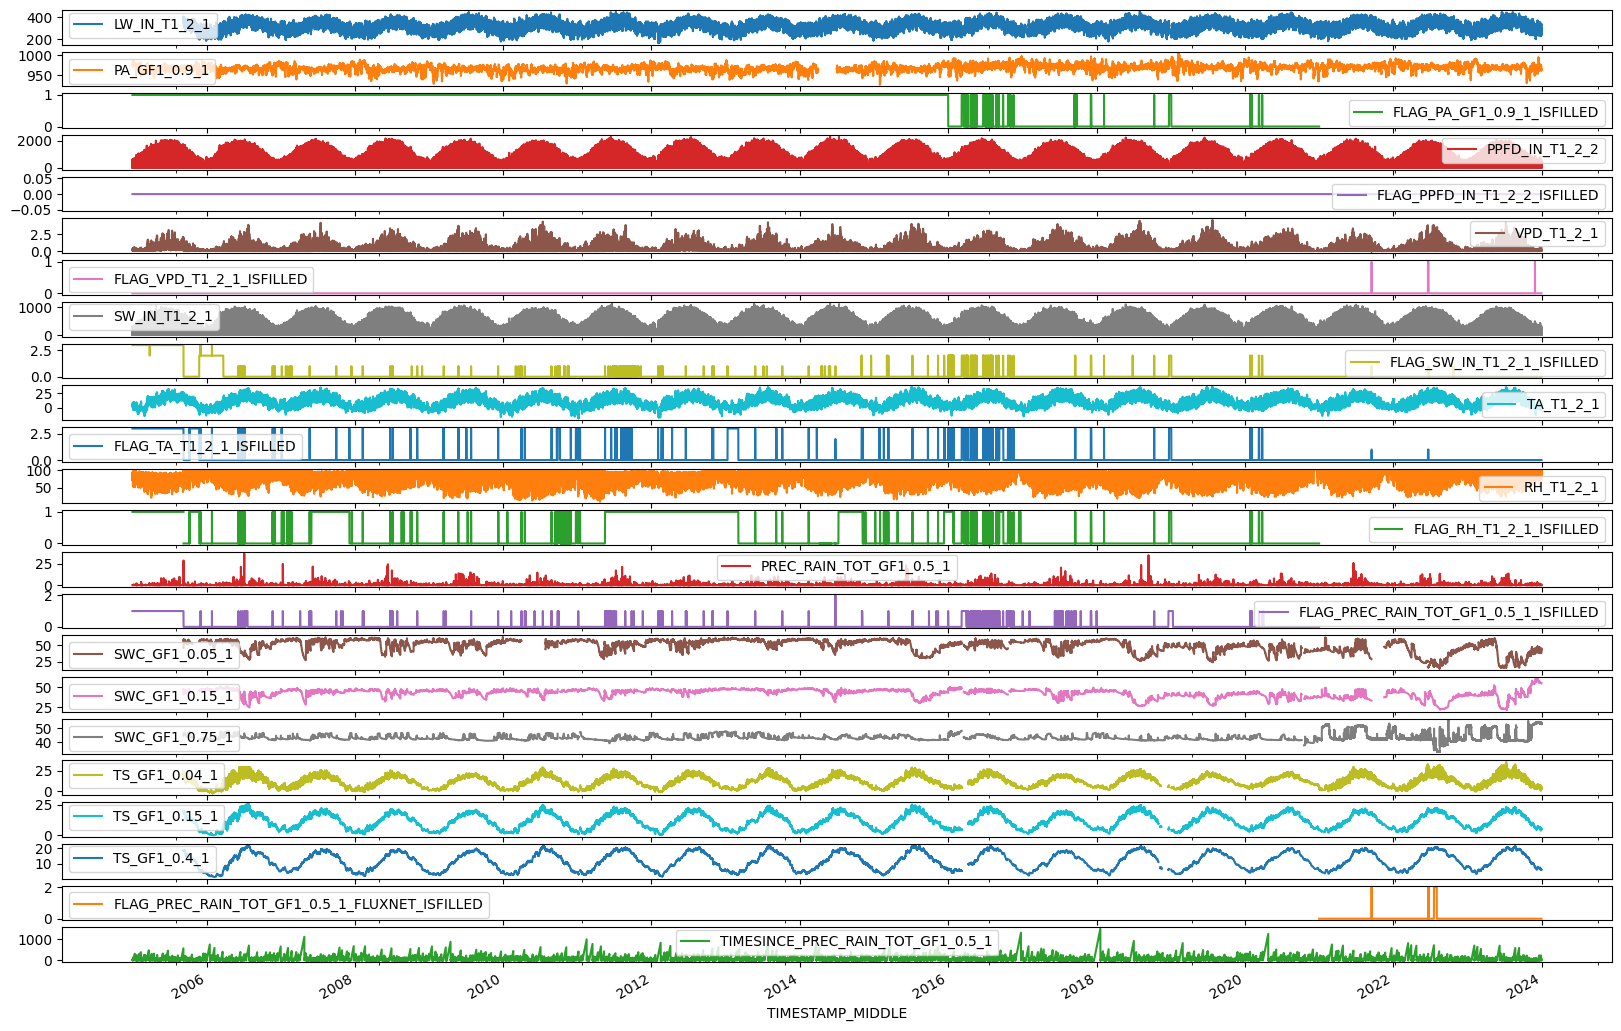

In [17]:
df_merged.plot(x_compat=True, subplots=True, figsize=(20, 14));

# Save to file

In [19]:
OUTNAME = "17.1_CH-CHA_meteo10_2005-2023"
OUTPATH = r"F:\Sync\luhk_work\20 - CODING\29 - WORKBENCH\dataset_cha_fp2024_2005-2023\notebooks\10_METEO"
filepath = save_parquet(filename=OUTNAME, data=df_merged, outpath=OUTPATH)
# df_merged.to_csv(Path(OUTPATH) / f"{OUTNAME}.csv")

Saved file F:\Sync\luhk_work\20 - CODING\29 - WORKBENCH\dataset_cha_fp2024_2005-2023\notebooks\10_METEO\17.1_CH-CHA_meteo10_2005-2023.parquet (0.304 seconds).
